<a id="topC"></a>

# Running the COS Pipeline (`calcos`)

# Learning Goals
### This Notebook is designed to walk the user (*you*) through:
#### 1. **[Setting up the environment to run `calcos`](#setupC)**
##### $\ \ \ \ $ 1.1. [Prerequisites](#prereqC)
##### $\ \ \ \ $ 1.2. [Create your conda environment](#condaenvC)
##### $\ \ \ \ $ 1.3. [Set up a reference file directory](#lrefC)


#### 2. **[Processing raw COS data using `calcos`](#runC)**
##### $\ \ \ \ $ 2.1. [Downloading the data](#datadlC)
##### $\ \ \ \ $ 2.2. [Gathering reference files](#reffileC)
##### $\ \ \ \ $ 2.3. [Running `calcos`: *From a python environment*](#runpyC)
##### $\ \ \ \ $ 2.4. [Running `calcos`: *From the command line*](#runcliC)


#### 3. **[Re-processing data COS data with altered parameters](#rerunC)**
##### $\ \ \ \ $ 3.1. [Altering the calibration switches](#alterswitchC)




# 0. Introduction
#### The Cosmic Origins Spectrograph ([*COS*](https://www.nasa.gov/content/hubble-space-telescope-cosmic-origins-spectrograph)) is an ultraviolet spectrograph on-board the Hubble Space Telescope ([*HST*](https://www.stsci.edu/hst/about)) with capabilities in the near ultraviolet (*NUV*) and far ultraviolet (*FUV*).

#### This tutorial aims to prepare you to begin analyzing COS data of your choice by walking you through reading and viewing a spectrum obtained with COS, as well as obtaining a few diagnostic measurements of your spectrum.

- For an in-depth manual to working with COS data and a discussion of caveats and user tips, see the [COS Data Handbook](https://hst-docs.stsci.edu/display/COSDHB/).
- For a detailed overview of the COS instrument, see the [COS Instrument Handbook](https://hst-docs.stsci.edu/display/COSIHB/).

#### **`Calcos`** is the data processing pipeline which converts the raw data produced by COS's detectors onboard Hubble into usable spectral data. It transitions the data from a list of many individual recorded photon interactions into tables of wavelength and flux.

#### Notes for those new to Python/Jupyter/Coding:
- You will frequently see exclamation points (**!**) or dollar signs (**\$**) at the beginning of a line of code. These are not part of the actual commands. The exclamation points tell a jupyter notebook to pass the following line to the command line, and the dollar sign merely indicates the start of a terminal prompt. 

## We will import the following packages:

- `astroquery.mast Mast and Observations` for finding and downloading data from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) archive
- `numpy` to handle array functions (version $\ge$ 1.17)
- `astropy.io` fits for accessing FITS files
- `astropy.table Table` for creating tidy tables of the data
<!-- - `astropy.units` and `astropy.visualization.quantity_support` for dealing with units -->
- `matplotlib.pyplot` for plotting data
- `glob` and `os` for searching and working with system files

- *Later on, we will import the `calcos` package to run out pipeline*

In [1]:
# This line is just to make any plots we might make look good in a notebook
%matplotlib inline

# Manipulating arrays
import numpy as np

# Reading in data
from astropy.io import fits
from astropy.table import Table

# Plotting
import matplotlib.pyplot as plt

# Downloading data from archive
from astroquery.mast import Observations

# Searching for files on our system
import glob
# Making directories and such
import os

## We will also define a few directories in which to place our data and plots, as well as a few colors we will use in plots later.

In [2]:
# These will be important directories for the notebook
cwd = !pwd
cwd = cwd[0]

!mkdir ./data
!mkdir ./output/

datadir = cwd + '/data/'
outputdir = cwd + '/output/'

mkdir: ./data: File exists


<a id = setupC></a>
# 1. Setting up the environment to run calcos

The first step to processing your data is setting up an environment from which to run `calcos`.
<a id = prereqC></a>
## 1.1. Prerequisites
This tutorial assumes some basic knowledge of the command line and was built using a unix bash-style shell. Those using a Windows computer will likely have the best results if working within the [Windows Subsystem for Linux](https://docs.microsoft.com/en-us/windows/wsl/install-win10).


If you do not already have any distribution of the `conda` tool, see [this page](https://astroconda.readthedocs.io/en/latest/getting_started.html#getting-started-jump) for instructions, and install either [`anaconda` - more beginner friendly, \~ 3 GB, lots of extras you likely won't use](https://docs.anaconda.com/anaconda/install/) or [`miniconda` - \~ 400 MB, only what you need](https://docs.conda.io/en/latest/miniconda.html).

<a id = condaenvC></a>
## 1.2. Create your conda environment
Once you have `conda` installed, it's time to create an environment. 

Open up your terminal app, likely `Terminal` or `iTerm` on a Mac or `Windows Terminal` or `Powershell` on Windows.

First, add the stsci channel to your computer's conda channel list. This enables conda to look in the right place to find all the packages we want to install.


``` $ conda config --add channels http://ssb.stsci.edu/astroconda```

Now we can create a new environment for running calcos; let's call it `calcos_env`, and initialize it with the packages in the stsci channel's list we just added.


``` $ conda create -n astroconda stsci ```

After allowing conda to proceed to installing the packages (type `y` then hit enter/return), you can see all of your environments with:

``` $ conda env list```

and then switch over to your new environment with 

``` $ conda activate calcos_env ```

At this point, typing `calcos` into the command line and hitting enter should no longer yield the error 

> ```command not found: calcos``` 

but rather respond that:

> ```The command-line options are:
  --version (print the version number and exit)
  -r (print the full version string and exit)
  ...
  ERROR:  An association file name or observation rootname must be specified.```

<a id = lrefC></a>
## 1.3. Set up a reference file directory

`calcos` needs to be able to find all your reference files, (flat field image, bad pixel table, etc.), and the best way to enable that is to create a central directory of all the calibration files you'll need. We refer to this directory  as "lref" by convention, and set a system variable `lref` to the location of the directory. 

We can assign a system variable in three different ways, depending on whether we are working from:
1. The command line
2. A python environment
3. A Jupyter Notebook

|Unix-style Command Line| Python | Jupyter Notebook|
|-|-|-|
| export lref='./data/reference' | import os| %env lref ./data/reference|
||os.environ["lref"] = "./data/reference" ||


Note that this system variable must be set again with every new instance of a terminal - if you frequently need to use the same `lref` directory, consider adding an export statement to your `.bash_profile` or equivalent file.

Because this is a jupyter notebook, we set our reference directory with the [cell magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html) below:

<!-- Looking in the headers of our data below, we see that the `$lref` argument appears at the beginning of all of the reference file locations: -->

In [3]:
%env lref ./data/reference/references/hst/cos/

env: lref=./data/reference/references/hst/cos/


We can note the value of the system variable using the `echo` command:

In [4]:
!echo $lref

./data/reference/references/hst/cos/


And finally we can create the directory with the line below.

<a id = runC></a>
# 2. Processing raw COS data using `calcos`

The calcos pipeline can be run either from a python environment, or directly from a Unix-style command line. The two use the same underlying machinery but can differ in syntax. For specifics on the keywords to run `calcos` with specific behaviors and arguments, see [Table 3.2: Arguments for Running calcos in Python](https://hst-docs.stsci.edu/cosdhb/chapter-3-cos-calibration/3-6-customizing-cos-data-calibration) and [Table 3.2:Command-line Options for Running calcos in Unix/Linux/Mac](https://hst-docs.stsci.edu/cosdhb/chapter-3-cos-calibration/3-6-customizing-cos-data-calibration).

<a id = datadlC></a>
## 2.1. Downloading the data

First, we need to make sure we have all of our data ready and in the right spot. If you are unfamiliar with searching the archive for data, we recommend that you view our [tutorial on downloading COS data](https://github.com/spacetelescope/COS-Notebooks). This notebook will largely gloss over downloading the data.

To run calcos, we will need the following files:
1. All the **raw data** from separate exposures we wish to combine as `rawtag` fits files
2. The **association** file telling calcos which files to combine as a `asn` fits file.

For this example, we're choosing the dataset `LCXV13040` of COS/FUV observing the [quasar 3C48](https://en.wikipedia.org/wiki/3C_48). In the cell below we download the data from the archive.

In [61]:
# query the MAST archive for data with observation id starting with lcxv1304
q1 = Observations.query_criteria(obs_id = 'lcxv1304*')

# Get a list of all products we could download associates with this file
pl = Observations.get_product_list(q1)

# Get a list of only the products which are association files
asn_file_list = pl[pl["productSubGroupDescription"] == 'ASN']

# Get a list of only the products which are rawtag files
rawtag_list = pl[(pl["productSubGroupDescription"] == 'RAWTAG_A') | (pl["productSubGroupDescription"] == 'RAWTAG_B')]

#Download the two lists to the data directory
Observations.download_products(rawtag_list, download_dir='./data')
Observations.download_products(asn_file_list, download_dir='./data')

Local Path,Status,Message,URL
str52,str8,object,object
./data/mastDownload/HST/lcxv13040/lcxv13040_asn.fits,COMPLETE,None,None


By default, each exposure's files are downloaded to separate directories, as is the association file.
We need to move around these files to all be in the same directory, which we do below.

In [62]:
!mv ./data/mastDownload/HST/lcxv13*/*fits* ./data
!rm -r ./data/mastDownload

<a id = reffileC></a>
## 2.2. Gathering reference files

Each data file has an associated set of calibration files which are needed to run the associated correction with (i.e. you need the `FLATFILE` to flat field correct the data.) These reference files must be located in the `$lref` directory to run the pipeline.

The Space Telescope Science Institute (STScI) team is regularly producing new calibration files, in an effort to keep improving data reduction. Periodically the pipeline is re-run on all COS data.
To determine which reference files were used most recently by STScI to calibrate your data (often, but not always the newest/best,) you can refer to your data file's "CRDS_CTX" keyword in its fits header (see next cell).

In [7]:
rawfiles = glob.glob('data/*raw*.fits')
crds_ctx = fits.getheader(rawfiles[0])['CRDS_CTX']
print(f"The CRDS Context last run with {rawfiles[0]} was:\t{crds_ctx}")

The CRDS Context last run with data/lcxv13ezq_rawtag_a.fits was:	hst_0836.pmap


The value of this keyword in the header is a `.pmap` file which tells the CRDS calibration data distribution program which files to distribute. To download the reference files specified by the context, we use the tool `crds`, installed with the stsci conda channel. 

Again, we first need to set some system variables to tell the program where to look and save the downloaded files. 

<img src= ../figures/warning.png width ="60" title="CAUTION!"> 

Note that as of the time of this notebook's creation, the context used below was **`hst_0836.pmap`**. You are running this in the future, and there is very possibly a newer context you would be better off working with. Take a minute to consider this, and check the results of the previous code cell before running the next cell.

Also note that this cell can produce quite a lot of output.

In [39]:
%env CRDS_SERVER_URL https://hst-crds.stsci.edu
%env CRDS_PATH ./data/reference/

# The next line depends on your context and pmap file 
!crds bestrefs --files data/*raw*.fits  --sync-references=2 --update-bestrefs --new-context 'hst_0836.pmap'

env: CRDS_SERVER_URL=https://hst-crds.stsci.edu
env: CRDS_PATH=./data/reference/
CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing data/lcxv13ezq_rawtag_a.fits
CRDS - INFO -  ===> Processing data/lcxv13ezq_rawtag_b.fits
CRDS - INFO -  ===> Processing data/lcxv13f4q_rawtag_a.fits
CRDS - INFO -  ===> Processing data/lcxv13f4q_rawtag_b.fits
CRDS - INFO -  ===> Processing data/lcxv13faq_rawtag_a.fits
CRDS - INFO -  ===> Processing data/lcxv13faq_rawtag_b.fits
CRDS - INFO -  ===> Processing data/lcxv13ffq_rawtag_a.fits
CRDS - INFO -  ===> Processing data/lcxv13ffq_rawtag_b.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  9 infos


### Now we can run the pipeline on our data using our reference files

This following cell running the pipeline can take several minutes, sometimes more than **10 minutes**, so you do *not* need to run this cell. It also outputs hundreds of lines of text if the verbosity parameter is set to 2.

<a id = runpyC></a>
## 2.3. Running `calcos`: *From a python environment*

First, we import the pipeline package:

In [11]:
import calcos

#### Now, we can run the pipeline program!

Note that generally, calcos should be run on an association file (in this case: `./data/lcxv13040_asn.fits`). In this case we also specify that `verbosity` = 2, resulting in a **very** verbose output, and we specify a directory to put all the output files in: `output/calcos_processed_1`. To avoid polluting this notebook with more than a thousand lines of the output, we capture the output of the next cell and save it to `output/output_calcos_1.txt` in the cell below.

In [29]:
%%capture cap --no-stderr
calcos.calcos('./data/lcxv13040_asn.fits', verbosity=2, outdir=outputdir+"/calcos_processed_1", )

In [32]:
with open(outputdir+'output_calcos_1.txt', 'w') as f: # This file now contains the output of the last cell
    f.write(cap.stdout)

<a id = runcliC></a>

## 2.4. Running `calcos`: *From the command line*

The syntax for running calcos from the command line is very similar. Assuming your data files, `lref` directory, and reference files are all in order, you can simply run:

```calcos --outdir directory_to_save_outputs_in filename_asn.fits```

*or, if you want to save a very verbose output to a log file `log.txt`*:

```calcos -v --outdir directory_to_save_outputs_in filename_asn.fits > log.txt```

To see the full list of commands, [Table 3.2:Command-line Options for Running calcos in Unix/Linux/Mac](https://hst-docs.stsci.edu/cosdhb/chapter-3-cos-calibration/3-6-customizing-cos-data-calibration), or run the following cell with no arguments.

In [41]:
!calcos

The command-line options are:
  --version (print the version number and exit)
  -r (print the full version string and exit)
  -q (quiet)
  -v (very verbose)
  -s (save temporary files)
  -o outdir (output directory name)
  --find yes (find Y location of spectrum)
  --find no (use Y location of spectrum from 1dx file and wavecal)
  --find cutoff (find Y location if sigma <= cutoff)
  --csum (create 'calcos sum' image)
  --only_csum (do little else but create csum)
  --raw (use raw coordinates for csum image)
  --compress parameters (compress csum image)
  --binx X_bin_factor (csum bin factor in X)
  --biny Y_bin_factor (csum bin factor in Y)
  --shift filename (file to specify shift values)
  --stim filename (append stim locations to filename)
  --live filename (append livetime factors to filename)
  --burst filename (append burst info to filename)

Following the options, list one or more association
files (rootname_asn) or raw files (rootname_raw).
ERROR:  An association file name or o

<a id = rerunC></a>
# 3. Re-processing data COS data with altered parameters

<a id = alterswitchC></a>
## 3.1. Altering the calibration switches



The way to tweak how `calcos` runs - which calibrations it performs - is with the calibration switches contained in the fits headers. The switches (with the exception of "XTRACTALG"), can be set to:

|"PERFORM"|"OMIT"|"N/A"|
|-|-|-|
|Performs the calibration step|Does not perform the calibration step|This step would not make sense for this file|

In the cell below, we get a full list of the switches by name. If you to learn more about the calibration steps and switches, see [Chapters 2 and 3 of the COS Data Handbook](https://hst-docs.stsci.edu/cosdhb).

In [53]:
header = fits.getheader(rawfiles[0])
calibswitches = header[82:109]
calibswitches

              / CALIBRATION SWITCHES: PERFORM, OMIT, COMPLETE                   
                                                                                
FLATCORR= 'PERFORM '           / apply flat-field correction                    
DEADCORR= 'PERFORM '           / correct for deadtime                           
DQICORR = 'PERFORM '           / data quality initialization                    
STATFLAG=                    T / Calculate statistics?                          
TEMPCORR= 'PERFORM '           / correct for thermal distortion                 
GEOCORR = 'PERFORM '           / correct FUV for geometic distortion            
DGEOCORR= 'OMIT    '           / Delta Corrections to FUV Geometric Distortion  
IGEOCORR= 'PERFORM '           / interpolate geometric distortion in INL file   
RANDCORR= 'PERFORM '           / add pseudo-random numbers to raw x and y       
RANDSEED=                   -1 / seed for pseudo-random number generator        
XWLKCORR= 'PERFORM '        

#### Let's begin by switching off all the switches currently set to "PERFORM", in every rawfile:

In [68]:
verbose = False 

for i, rawfile in enumerate(rawfiles):
    if verbose:
        print(rawfile)
    header = fits.getheader(rawfiles[i])
    corrections = [key for key in list(header.keys()) if "CORR" in key]

    for correction in corrections:
        if header[correction] == 'PERFORM':
            if verbose:
                print("switching\t", header[correction], "\t",correction, "\tto OMIT")
            fits.setval(rawfile, correction, value='OMIT', ext = 0)

#### `calcos` realizes that all the switches are set to "OMIT", and exits without doing anything.

In [70]:
calcos.calcos('./data/lcxv13040_asn.fits', verbosity=0, outdir=outputdir+"calcos_processed_2" )

CALCOS version 3.3.9
numpy version 1.19.2
astropy version 4.0.2
Nothing to do; all calibration switches are OMIT.


0

In [71]:
break

SyntaxError: 'break' outside loop (<ipython-input-71-6aaf1f276005>, line 4)

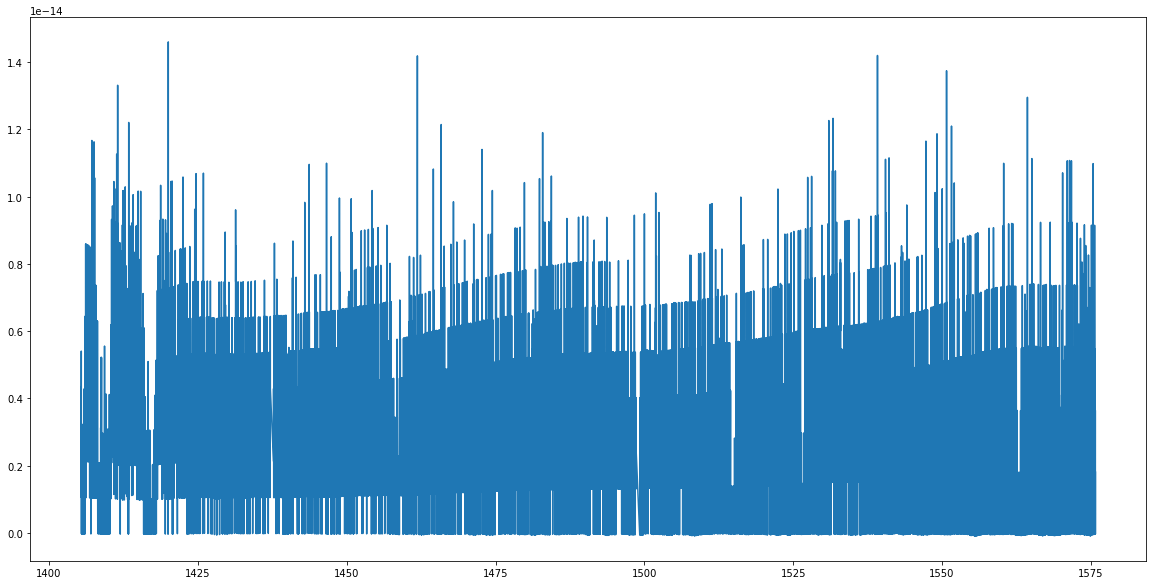

In [139]:
output_spectrum = Table.read('new2/lcxv13040_x1dsum.fits')
wvln, flux, fluxErr, dqwgt = output_spectrum[1]["WAVELENGTH", "FLUX", "ERROR" ,"DQ_WGT"]
dqwgt = np.asarray(dqwgt, dtype=bool)


plt.figure(figsize=(20,10))
plt.plot(wvln[dqwgt], flux[dqwgt],)

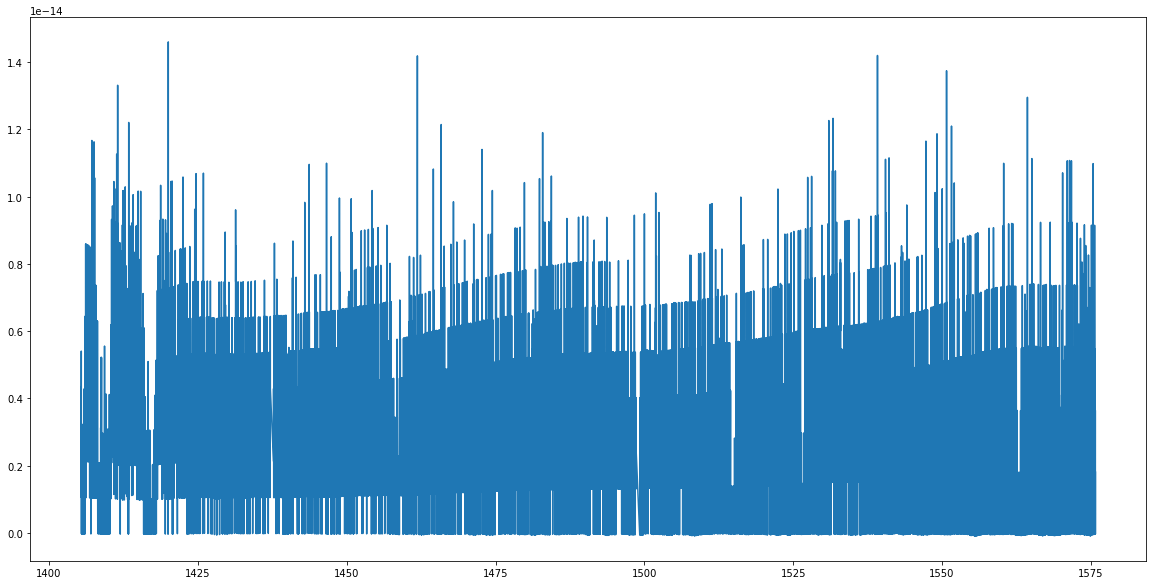

In [151]:
output_spectrum = Table.read('/Users/nkerman/Projects/COS-Notebooks/Calcos/mastDownload/HST/lcxv13040copy/lcxv13040_x1dsum1.fits')
wvln_orig, flux_orig, fluxErr_orig, dqwgt_orig = output_spectrum[1]["WAVELENGTH", "FLUX", "ERROR" ,"DQ_WGT"]
dqwgt_orig = np.asarray(dqwgt_orig, dtype=bool)


plt.figure(figsize=(20,10))
plt.plot(wvln[dqwgt_orig], flux[dqwgt_orig])

In [104]:
dqwgt.size, dqwgt[dqwgt].size

(16384, 16384)

In [111]:
wvln, wvln[dqwgt ==1]

(array([1386.68454682, 1386.6967854 , 1386.70902398, ..., 1587.16466588,
        1587.17690445, 1587.18914303]),
 array([1405.34837575, 1405.36061432, 1405.3728529 , ..., 1575.74607415,
        1575.75831273, 1575.7705513 ]))

In [110]:
flux[list(dqwgt)]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [98]:
pl[pl['productType'] == 'AUXILIARY']

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid
str10,str3,str8,str9,str62,str1,str44,str9,str28,str9,str1,str6,str6,str5,str27,int64,str10
2004636330,HST,spectrum,lcxv13040,DADS JIF file,C,mast:HST/product/lcxv13040_jif.fits,AUXILIARY,--,JIF,--,CALCOS,--,14268,lcxv13040_jif.fits,112320,2004636330
2004636330,HST,spectrum,lcxv13040,DADS JIT file,C,mast:HST/product/lcxv13040_jit.fits,AUXILIARY,--,JIT,--,CALCOS,--,14268,lcxv13040_jit.fits,216000,2004636330
2004636330,HST,spectrum,lcxv13040,DADS TRL file - Processing log,C,mast:HST/product/lcxv13040_trl.fits,AUXILIARY,--,TRL,--,CALCOS,--,14268,lcxv13040_trl.fits,164160,2004636330
2004636330,HST,spectrum,lcxv13040,DADS X1S file - Summed 1D spectrum COS,C,mast:HST/product/lcxv13040_x1dsum1.fits,AUXILIARY,--,X1DSUM1,--,CALCOS,3.3.10,14268,lcxv13040_x1dsum1.fits,1941120,2004636330
2004636330,HST,spectrum,lcxv13040,DADS X2S file - Summed 1D spectrum COS,C,mast:HST/product/lcxv13040_x1dsum2.fits,AUXILIARY,--,X1DSUM2,--,CALCOS,3.3.10,14268,lcxv13040_x1dsum2.fits,1941120,2004636330
2004636330,HST,spectrum,lcxv13040,DADS X3S file - Summed 1D spectrum COS,C,mast:HST/product/lcxv13040_x1dsum3.fits,AUXILIARY,--,X1DSUM3,--,CALCOS,3.3.10,14268,lcxv13040_x1dsum3.fits,1941120,2004636330
2004636330,HST,spectrum,lcxv13040,DADS X4S file - Summed 1D spectrum COS,C,mast:HST/product/lcxv13040_x1dsum4.fits,AUXILIARY,--,X1DSUM4,--,CALCOS,3.3.10,14268,lcxv13040_x1dsum4.fits,1941120,2004636330
2004636330,HST,spectrum,lcxv13040,DADS ASN file - Association ACS/WFC3/STIS,C,mast:HST/product/lcxv13040_asn.fits,AUXILIARY,Minimum Recommended Products,ASN,--,CALCOS,3.3.10,14268,lcxv13040_asn.fits,11520,2004636330
2004636068,HST,spectrum,lcxv13ezq,DADS CTA file - Corrected events COS segment A,S,mast:HST/product/lcxv13ezq_corrtag_a.fits,AUXILIARY,--,CORRTAG_A,--,CALCOS,3.3.10,14268,lcxv13ezq_corrtag_a.fits,1215360,2004636330
